In [2]:
import os
import h5py
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.layers import Activation,AveragePooling2D,Conv2D, RepeatVector, Permute, Multiply
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tcn import TCN
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.layers import LSTM

import numpy as np
import h5py
import glob # Used to find all file paths
import os

In [3]:
BASE_PATH_CROSS = 'Final Project data/Cross'
BASE_PATH_INTRA = 'Final Project data/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')

# Constants
N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
WINDOW_SIZE = 150
STEP = 50

#loading and preprocessing funcs
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files:
        raise FileNotFoundError(f"No file found")
    return files

def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename:
            task = 'rest'
        elif 'motor' in filename:
            task = 'task_motor'
        elif 'story' in filename or 'math' in filename:
            task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename:
            task = 'task_working_memory'

        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f:
                dataset_name = list(f.keys())[0]
                matrix = f[dataset_name][()]
                data.append(matrix)
    return np.array(data), np.array(labels)

def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            start=j*step
            end = start +window_size
            X_win.append(data[i, :, start:end])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)

def normalize_data(data):
    """function for appluing time wise z-score normalization to each window"""
    n_samples, n_channels, n_timesteps = data.shape
    # reshape for scaler: (samples * channels, timesteps)
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    scaler = StandardScaler()

    scaled_data = scaler.fit_transform(reshaped_data)
    #reshap back to original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

def augment_data(data, labels, noise_factor=0.05, scale_factor_range=(0.9, 1.1)):
    """applies noises and scaling augmentation"""
    augmented_data, augmented_labels = [], []
    for i in range(len(data)):
        original_sample = data[i]
        original_label = labels[i]
        # add org sample
        augmented_data.append(original_sample)
        augmented_labels.append(original_label)
        # add augmented sample
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=original_sample.shape)
        scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
        augmented_sample = (original_sample + noise) * scaler
        augmented_data.append(augmented_sample)
        augmented_labels.append(original_label)
    return np.array(augmented_data), np.array(augmented_labels)


# preproccessing
def preprocess_pipeline(base_dir, is_training=True, output_format='2d'):

    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]

    X_win, y_win = windowing(X_ds, y, WINDOW_SIZE, STEP)

    X_norm = normalize_data(X_win)

    if is_training:
        X_aug, y_aug = augment_data(X_norm, y_win)
        final_X, final_y = X_aug, y_aug
    else:
        final_X, final_y = X_norm, y_win

    if output_format == '2d':
        # Reshape for EEGNet/2D CNNs by adding a final dimension
        final_X = final_X[..., np.newaxis]
    elif output_format == '1d':
        # Reshape for Simple/1D CNNs by swapping the last two axes
        final_X = np.transpose(final_X, (0, 2, 1))
    else:
        raise ValueError("Invalid output_format")

    return final_X, final_y

X_train_1D, y_train_1D_final = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True, output_format='1d')
X_test1_1D, y_test1_1D_final = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='1d')
X_test2_1D, y_test2_1D_final = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='1d')
X_test3_1D, y_test3_1D_final = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='1d')

X_train_augmented = X_train_1D
y_train_augmented = y_train_1D_final
NUM_CLASSES = len(np.unique(y_train_1D_final))

INPUT_SHAPE = (X_train_1D.shape[1], X_train_1D.shape[2])

# CNN

In [4]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

simple_cnn = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)

simple_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

simple_cnn.summary()

# --- Training ---
simple_cnn.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_simple_cnn, acc1_simple_cnn = simple_cnn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = simple_cnn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = simple_cnn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 150, 64)        │       158,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 37, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,700 (1.49 MB)

 Trainable params: 389,316 (1.49 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
221/221 - 5s - 23ms/step - accuracy: 0.9850 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 2.9878e-04
Epoch 2/20
221/221 - 4s - 16ms/step - accuracy: 0.9936 - loss: 0.0498 - val_accuracy: 1.0000 - val_loss: 3.4358e-04
Epoch 3/20
221/221 - 4s - 16ms/step - accuracy: 0.9999 - loss: 4.5151e-04 - val_accuracy: 1.0000 - val_loss: 7.2582e-05
Epoch 4/20
221/221 - 4s - 16ms/step - accuracy: 1.0000 - loss: 1.2934e-04 - val_accuracy: 1.0000 - val_loss: 1.0536e-05
Epoch 5/20
221/221 - 4s - 16ms/step - accuracy: 1.0000 - loss: 5.1171e-05 - val_accuracy: 1.0000 - val_loss: 4.6666e-05
Epoch 6/20
221/221 - 4s - 16ms/step - accuracy: 1.0000 - loss: 8.1121e-05 - val_accuracy: 1.0000 - val_loss: 7.9556e-06
Epoch 7/20
221/221 - 4s - 17ms/step - accuracy: 1.0000 - loss: 4.4190e-05 - val_accuracy: 1.0000 - val_loss: 7.8982e-07
Epoch 8/20
221/221 - 4s - 17ms/step - accuracy: 1.0000 - loss: 4.7532e-05 - val_accuracy: 1.0000 - val_loss: 5.8179e-07
Epoch 9/20
221/221 - 4s - 17ms/step - accuracy: 

# LSTM

In [5]:
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Convolutional layers to extract features
        Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        # LSTM layer to model temporal sequences of the extracted features
        LSTM(128, return_sequences=False), # return_sequences=False  it's the last recurrent layer

        # Dense layers for classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, NUM_CLASSES)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

# --- Training ---
cnn_lstm_model.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_hybrid, acc1_hybrid = cnn_lstm_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = cnn_lstm_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = cnn_lstm_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 150, 64)        │       158,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 37, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,212 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
221/221 - 6s - 26ms/step - accuracy: 0.9878 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 2.5532e-04
Epoch 2/20
221/221 - 4s - 20ms/step - accuracy: 1.0000 - loss: 5.4023e-04 - val_accuracy: 1.0000 - val_loss: 7.9662e-04
Epoch 3/20
221/221 - 4s - 20ms/step - accuracy: 0.9958 - loss: 0.0169 - val_accuracy: 0.9943 - val_loss: 0.0247
Epoch 4/20
221/221 - 4s - 20ms/step - accuracy: 1.0000 - loss: 4.6523e-04 - val_accuracy: 0.9989 - val_loss: 0.0023
Epoch 5/20
221/221 - 4s - 20ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9887 - val_loss: 0.0385
Epoch 6/20
221/221 - 4s - 20ms/step - accuracy: 1.0000 - loss: 3.2366e-04 - val_accuracy: 1.0000 - val_loss: 3.6405e-05
Epoch 7/20
221/221 - 4s - 20ms/step - accuracy: 0.9966 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 5.8191e-05
Epoch 8/20
221/221 - 4s - 20ms/step - accuracy: 1.0000 - loss: 3.1586e-04 - val_accuracy: 1.0000 - val_loss: 8.1452e-06
Epoch 9/20
221/221 - 4s - 20ms/step - accuracy: 0.9997 - loss: 0.001

# Attention

In [6]:
def build_temporal_attention_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, 15, padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(4)(x)
    x = Conv1D(128, 15, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(4)(x)

    # Attention-like mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(128)(attention)
    attention = Permute([2, 1])(attention)

    x = Multiply()([x, attention])
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

temporal_attention_model = build_temporal_attention_model(INPUT_SHAPE, NUM_CLASSES)

temporal_attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

temporal_attention_model.summary()

# --- Training ---
temporal_attention_model.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)

# Evaluate on test sets
loss1_temporal_attention, acc1_temporal_attention = temporal_attention_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"temporal_attention Model Accuracy on Test Set 1: {acc1_temporal_attention * 100:.2f}%")
loss2_temporal_attention, acc2_temporal_attention = temporal_attention_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"temporal_attention Model Accuracy on Test Set 2: {acc2_temporal_attention * 100:.2f}%")
loss3_temporal_attention, acc3_temporal_attention = temporal_attention_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"temporal_attention Model Accuracy on Test Set 3: {acc3_temporal_attention * 100:.2f}%")

print(f"Average accuracy: {((acc1_temporal_attention + acc2_temporal_attention +acc3_temporal_attention)/3) * 100:.2f}%")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 248)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 150, 64)   │    238,144 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 37, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 37, 128)   │    123,008 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 128)   │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 9, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 9, 1)      │        129 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 9)         │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9)         │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 9)    │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 9, 128)    │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 9, 128)    │          0 │ max_pooling1d_5[… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1152)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1152)      │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │      4,612 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 366,661 (1.40 MB)

 Trainable params: 366,277 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
221/221 - 5s - 24ms/step - accuracy: 0.9909 - loss: 0.0461 - val_accuracy: 1.0000 - val_loss: 0.0577
Epoch 2/20
221/221 - 5s - 21ms/step - accuracy: 1.0000 - loss: 4.7654e-04 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 3/20
221/221 - 5s - 21ms/step - accuracy: 1.0000 - loss: 1.6074e-04 - val_accuracy: 1.0000 - val_loss: 1.5587e-04
Epoch 4/20
221/221 - 5s - 21ms/step - accuracy: 1.0000 - loss: 9.0044e-05 - val_accuracy: 1.0000 - val_loss: 4.8603e-05
Epoch 5/20
221/221 - 5s - 22ms/step - accuracy: 1.0000 - loss: 5.7049e-05 - val_accuracy: 1.0000 - val_loss: 3.1415e-05
Epoch 6/20
221/221 - 5s - 22ms/step - accuracy: 1.0000 - loss: 3.7133e-05 - val_accuracy: 1.0000 - val_loss: 2.0920e-05
Epoch 7/20
221/221 - 5s - 21ms/step - accuracy: 1.0000 - loss: 3.0999e-05 - val_accuracy: 1.0000 - val_loss: 1.5145e-05
Epoch 8/20
221/221 - 5s - 21ms/step - accuracy: 1.0000 - loss: 2.1018e-05 - val_accuracy: 1.0000 - val_loss: 7.9810e-06
Epoch 9/20
221/221 - 5s - 21ms/step - accuracy: 1.00

# TCN

In [7]:
def build_tcn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16], return_sequences=False),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

build_tcn_model_model = build_tcn_model(INPUT_SHAPE, NUM_CLASSES)

build_tcn_model_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

build_tcn_model_model.summary()

# --- Training ---
build_tcn_model_model.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_build_tcn_model, acc1_build_tcn_model = build_tcn_model_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
loss2_build_tcn_model, acc2_build_tcn_model = build_tcn_model_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
loss3_build_tcn_model, acc3_build_tcn_model = build_tcn_model_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,516 (1.07 MB)

 Trainable params: 280,516 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
221/221 - 9s - 42ms/step - accuracy: 0.9567 - loss: 0.2621 - val_accuracy: 1.0000 - val_loss: 2.7528e-05
Epoch 2/20
221/221 - 8s - 37ms/step - accuracy: 1.0000 - loss: 1.8853e-04 - val_accuracy: 1.0000 - val_loss: 2.3807e-06
Epoch 3/20
221/221 - 8s - 38ms/step - accuracy: 1.0000 - loss: 4.5369e-05 - val_accuracy: 1.0000 - val_loss: 4.8520e-07
Epoch 4/20
221/221 - 8s - 36ms/step - accuracy: 1.0000 - loss: 3.6448e-05 - val_accuracy: 1.0000 - val_loss: 5.4814e-07
Epoch 5/20
221/221 - 8s - 38ms/step - accuracy: 1.0000 - loss: 4.8950e-05 - val_accuracy: 1.0000 - val_loss: 4.0458e-07
Epoch 6/20
221/221 - 8s - 38ms/step - accuracy: 1.0000 - loss: 4.6812e-05 - val_accuracy: 1.0000 - val_loss: 3.6363e-07
Epoch 7/20
221/221 - 8s - 37ms/step - accuracy: 1.0000 - loss: 1.7688e-05 - val_accuracy: 1.0000 - val_loss: 1.2542e-07
Epoch 8/20
221/221 - 8s - 37ms/step - accuracy: 1.0000 - loss: 2.7509e-05 - val_accuracy: 1.0000 - val_loss: 1.8613e-07
Epoch 9/20
221/221 - 8s - 37ms/step - accura

# Optimization

In [8]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def make_optimized_objective(build_model_fn, max_epochs=10, batch_size=32):
    best_model_container = {"model": None, "best_acc": 0.0}

    def objective(trial):
        window_size = trial.suggest_int("window_size", 100, 400, step=50)
        step_size = trial.suggest_int("step_size", 25, 300, step=25)

        # Re-run preprocessing with new window and step sizes
        global WINDOW_SIZE, STEP
        WINDOW_SIZE = window_size
        STEP = step_size

        X_train, y_train = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True, output_format='1d')
        X_test1, y_test1 = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='1d')
        X_test2, y_test2 = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='1d')
        X_test3, y_test3 = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='1d')

        # Validate shape
        if X_train.shape[1] != window_size:
            return 0.0

        num_classes = len(np.unique(y_train))
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_model_fn(input_shape, num_classes)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42)

        model.fit(
            X_train_sub, y_train_sub,
            validation_data=(X_val_sub, y_val_sub),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
        )

        _, acc1 = model.evaluate(X_test1, y_test1, verbose=0)
        _, acc2 = model.evaluate(X_test2, y_test2, verbose=0)
        _, acc3 = model.evaluate(X_test3, y_test3, verbose=0)
        avg_acc = (acc1 + acc2 + acc3) / 3

        if avg_acc > best_model_container["best_acc"]:
            best_model_container["model"] = model
            best_model_container["best_acc"] = avg_acc

        return avg_acc

    return objective, best_model_container




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
objective, best_model_container_cnn = make_optimized_objective(build_cnn_model)
study_cnn = optuna.create_study(direction='maximize')
study_cnn.optimize(objective, n_trials=20)

best_model_cnn = best_model_container_cnn["model"]
print("Best average accuracy:", best_model_container_cnn["best_acc"])
print("Best parameters:", study_cnn.best_params)

[I 2025-06-15 16:40:11,369] A new study created in memory with name: no-name-f32d0053-6abb-489c-9ce5-9f59c4a5c69e
[I 2025-06-15 16:40:25,449] Trial 0 finished with value: 0.675347238779068 and parameters: {'window_size': 150, 'step_size': 300}. Best is trial 0 with value: 0.675347238779068.
[I 2025-06-15 16:40:54,790] Trial 1 finished with value: 0.6527777711550394 and parameters: {'window_size': 300, 'step_size': 125}. Best is trial 0 with value: 0.675347238779068.
[I 2025-06-15 16:41:06,373] Trial 2 finished with value: 0.6650641063849131 and parameters: {'window_size': 100, 'step_size': 275}. Best is trial 0 with value: 0.675347238779068.
[I 2025-06-15 16:41:21,686] Trial 3 finished with value: 0.6875 and parameters: {'window_size': 250, 'step_size': 275}. Best is trial 3 with value: 0.6875.
[I 2025-06-15 16:41:38,310] Trial 4 finished with value: 0.6759751737117767 and parameters: {'window_size': 100, 'step_size': 75}. Best is trial 3 with value: 0.6875.
[I 2025-06-15 16:41:52,359]

Best average accuracy: 0.7038043340047201
Best parameters: {'window_size': 150, 'step_size': 75}


In [10]:
objective, best_model_container_lstm = make_optimized_objective(build_cnn_lstm_model)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_model_lstm = best_model_container_lstm["model"]
print("Best average accuracy:", best_model_container_lstm["best_acc"])
print("Best parameters:", study.best_params)

[I 2025-06-15 16:55:18,461] A new study created in memory with name: no-name-e3e5b178-e653-44ff-84c6-3e12a35bc1e4
[I 2025-06-15 16:55:47,960] Trial 0 finished with value: 0.6236111124356588 and parameters: {'window_size': 200, 'step_size': 75}. Best is trial 0 with value: 0.6236111124356588.
[I 2025-06-15 16:56:52,972] Trial 1 finished with value: 0.653585265080134 and parameters: {'window_size': 400, 'step_size': 75}. Best is trial 1 with value: 0.653585265080134.
[I 2025-06-15 16:57:08,930] Trial 2 finished with value: 0.6753472288449606 and parameters: {'window_size': 350, 'step_size': 275}. Best is trial 2 with value: 0.6753472288449606.
[I 2025-06-15 16:57:36,647] Trial 3 finished with value: 0.6491228143374125 and parameters: {'window_size': 400, 'step_size': 175}. Best is trial 2 with value: 0.6753472288449606.
[I 2025-06-15 16:57:53,639] Trial 4 finished with value: 0.7147435943285624 and parameters: {'window_size': 200, 'step_size': 275}. Best is trial 4 with value: 0.71474359

Best average accuracy: 0.724702388048172
Best parameters: {'window_size': 150, 'step_size': 250}


In [11]:
objective, best_model_container_tcn = make_optimized_objective(build_tcn_model)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_model_tcn = best_model_container_tcn["model"]
print("Best average accuracy:", best_model_container_tcn["best_acc"])
print("Best parameters:", study.best_params)

[I 2025-06-15 17:25:03,676] A new study created in memory with name: no-name-a1cf9a13-0220-461b-a6aa-03c66520af87


[I 2025-06-15 17:27:59,057] Trial 0 finished with value: 0.6132907470067342 and parameters: {'window_size': 150, 'step_size': 25}. Best is trial 0 with value: 0.6132907470067342.
[I 2025-06-15 17:28:29,142] Trial 1 finished with value: 0.6267361144224802 and parameters: {'window_size': 250, 'step_size': 300}. Best is trial 1 with value: 0.6267361144224802.
[I 2025-06-15 17:28:41,921] Trial 2 finished with value: 0.6947916646798452 and parameters: {'window_size': 100, 'step_size': 175}. Best is trial 2 with value: 0.6947916646798452.
[I 2025-06-15 17:31:33,358] Trial 3 finished with value: 0.7162408729394277 and parameters: {'window_size': 150, 'step_size': 25}. Best is trial 3 with value: 0.7162408729394277.
[I 2025-06-15 17:32:15,491] Trial 4 finished with value: 0.6236111025015513 and parameters: {'window_size': 350, 'step_size': 225}. Best is trial 3 with value: 0.7162408729394277.
[I 2025-06-15 17:32:57,109] Trial 5 finished with value: 0.6496913532416025 and parameters: {'window_s

Best average accuracy: 0.7336309552192688
Best parameters: {'window_size': 100, 'step_size': 250}


In [13]:
# Evaluate on test sets for CNN
loss1_simple_cnn, acc1_simple_cnn = best_model_cnn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = best_model_cnn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = best_model_cnn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")


# Evaluate on test sets for LSTM
loss1_hybrid, acc1_hybrid = best_model_lstm.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = best_model_lstm.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = best_model_lstm.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")



# Evaluate on test sets for TCN
loss1_build_tcn_model, acc1_build_tcn_model = best_model_tcn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
loss2_build_tcn_model, acc2_build_tcn_model = best_model_tcn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
loss3_build_tcn_model, acc3_build_tcn_model = best_model_tcn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")

simple_cnn Model Accuracy on Test Set 1: 97.19%
simple_cnn Model Accuracy on Test Set 2: 43.93%
simple_cnn Model Accuracy on Test Set 3: 69.84%
Average accuracy: 70.32%
Hybrid Model Accuracy on Test Set 1: 93.30%
Hybrid Model Accuracy on Test Set 2: 46.29%
Hybrid Model Accuracy on Test Set 3: 78.53%
Average accuracy: 72.71%
temporal attention Model Accuracy on Test Set 1: 95.02%
temporal attention Model Accuracy on Test Set 2: 46.29%
temporal attention Model Accuracy on Test Set 3: 76.45%
Average accuracy: 72.58%


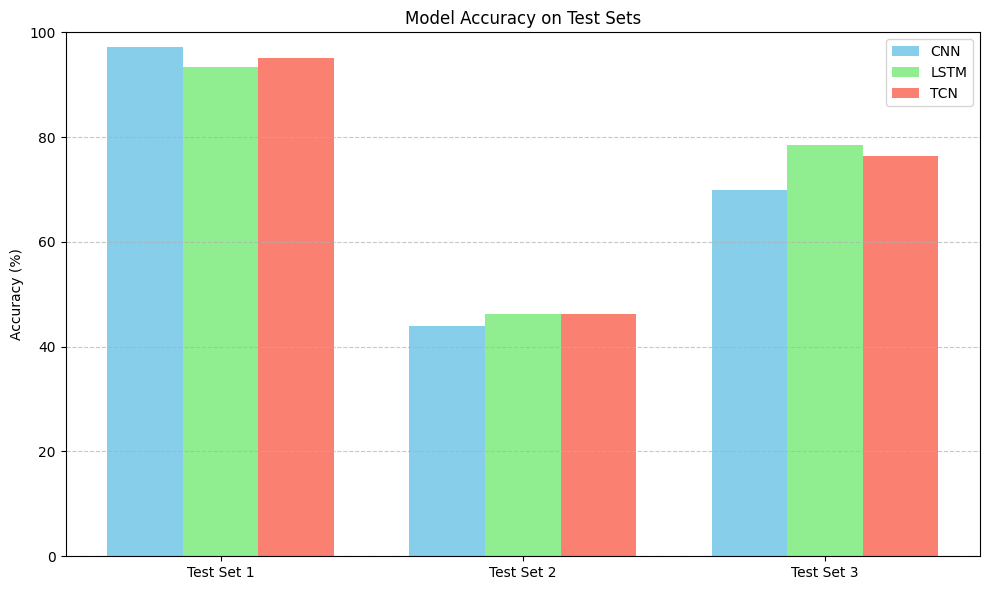

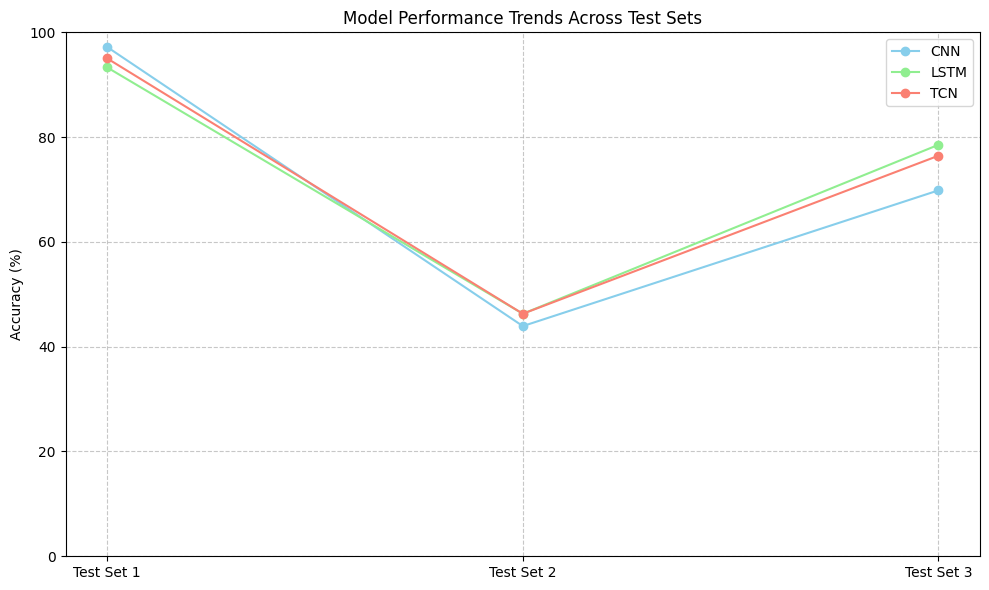

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracies (convert to percentages for plotting)
cnn_accs = [acc1_simple_cnn * 100, acc2_simple_cnn * 100, acc3_simple_cnn * 100]
lstm_accs = [acc1_hybrid * 100, acc2_hybrid * 100, acc3_hybrid * 100]
tcn_accs = [acc1_build_tcn_model * 100, acc2_build_tcn_model * 100, acc3_build_tcn_model * 100]

test_sets = ['Test Set 1', 'Test Set 2', 'Test Set 3']
x = np.arange(len(test_sets))
width = 0.25  # bar width

# === Grouped Bar Plot ===
plt.figure(figsize=(10, 6))
plt.bar(x - width, cnn_accs, width, label='CNN', color='skyblue')
plt.bar(x, lstm_accs, width, label='LSTM', color='lightgreen')
plt.bar(x + width, tcn_accs, width, label='TCN', color='salmon')

plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Test Sets')
plt.xticks(x, test_sets)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Line Plot for Model Trends ===
plt.figure(figsize=(10, 6))
plt.plot(test_sets, cnn_accs, marker='o', label='CNN', color='skyblue')
plt.plot(test_sets, lstm_accs, marker='o', label='LSTM', color='lightgreen')
plt.plot(test_sets, tcn_accs, marker='o', label='TCN', color='salmon')

plt.ylabel('Accuracy (%)')
plt.title('Model Performance Trends Across Test Sets')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


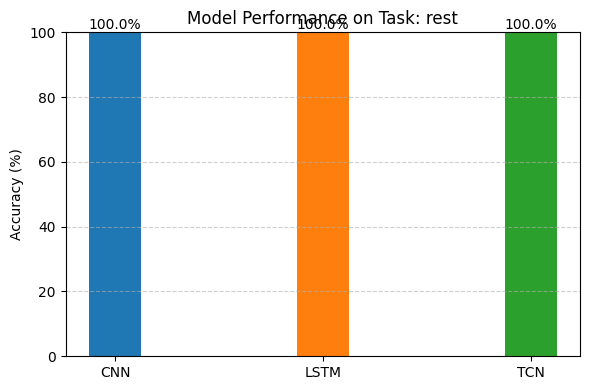

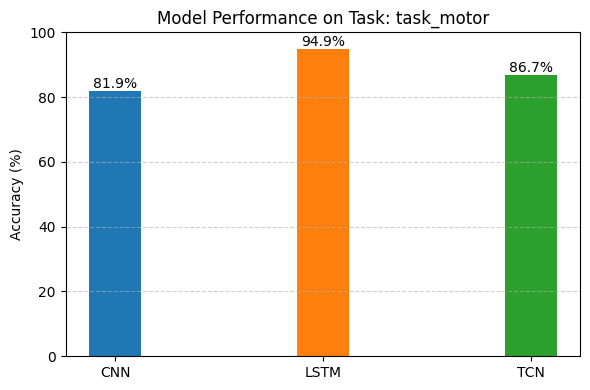

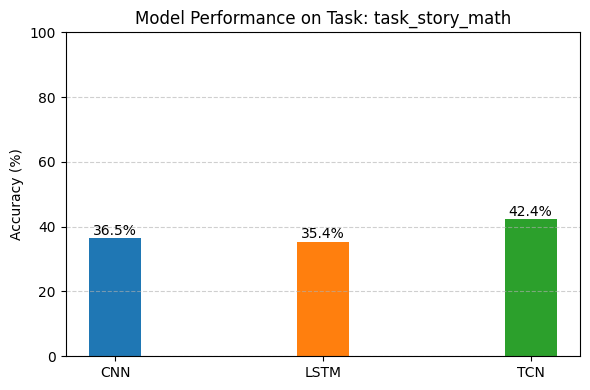

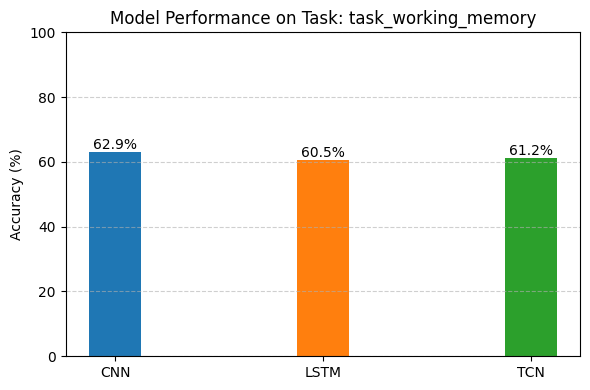

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# List of test sets and labels
X_tests = [X_test1_1D, X_test2_1D, X_test3_1D]
y_tests = [y_test1_1D_final, y_test2_1D_final, y_test3_1D_final]
task_names = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']

# Store model predictions
model_preds = {
    "CNN": [],
    "LSTM": [],
    "TCN": []
}

# Store ground truths
all_y_true = []

# Collect predictions from all models
for X, y_true in zip(X_tests, y_tests):
    model_preds["CNN"].append(np.argmax(best_model_cnn.predict(X, verbose=0), axis=1))
    model_preds["LSTM"].append(np.argmax(best_model_lstm.predict(X, verbose=0), axis=1))
    model_preds["TCN"].append(np.argmax(best_model_tcn.predict(X, verbose=0), axis=1))
    all_y_true.append(y_true)

# Combine across all test sets
y_true_all = np.concatenate(all_y_true)
preds_all = {
    name: np.concatenate(pred_list) for name, pred_list in model_preds.items()
}

# Calculate per-task accuracy
task_performance = {name: [] for name in model_preds}

for label in range(4):  # for each task
    indices = np.where(y_true_all == label)[0]
    for model_name in preds_all:
        acc = accuracy_score(y_true_all[indices], preds_all[model_name][indices])
        task_performance[model_name].append(acc * 100)  # convert to %

# Plot
x = np.arange(len(model_preds))  # 3 models
width = 0.25

for i, task in enumerate(task_names):
    plt.figure(figsize=(6, 4))
    scores = [task_performance[model][i] for model in model_preds]
    plt.bar(x, scores, width, tick_label=list(model_preds.keys()), color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.title(f"Model Performance on Task: {task}")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for j, score in enumerate(scores):
        plt.text(j, score + 1, f"{score:.1f}%", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()
